# Numerical Scheme 2D Wavefield

Input is a distribution of frequencies $\omega_n$ with weights $a_n$. There is a then a number of modes m. From m,n through the dispersion relation the horizontal wave number is fixed to be $k_{mn}$

To generate a two-dimensional field we construct a sum over all these frequencies and modes. 

$$ \zeta = \sum_n a_n e^{i \omega_{n} t}\sum_m \phi_{nm}(z) \otimes e^{i k_{nm} x} $$

<IPython.core.display.Javascript object>


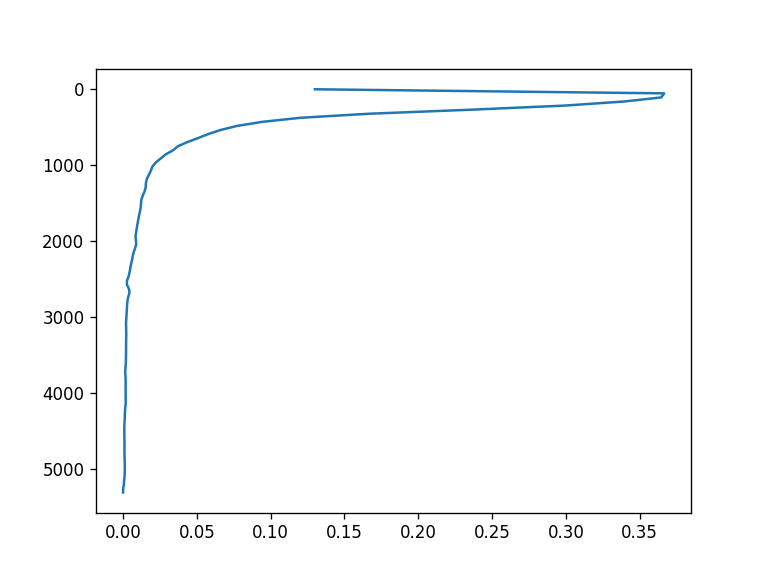

13285.0


In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext jupyter_spaces
%matplotlib notebook
import seawater as sw
import oceansdb
import src.oceandepth as od
import src.iw_vmodes  as iwvm
import matplotlib.pyplot as plt

LAT = 20
LON = 150
NP  = 100

#Grab Bottom Depth
dbb = oceansdb.ETOPO()
H = abs(dbb['topography'].extract(lat=LAT, lon=-LON)['height'][0])
odepth = od.odepth(H, NP,lat=LAT)
z = odepth.get_dim('z')

#Grab profile from data set
db = oceansdb.WOA()
SD = db['sea_water_salinity'].extract(var='mean',depth=z,doy=136.875,lat=LAT,lon=-LON)
TD = db['sea_water_temperature'].extract(var='mean',depth=z,doy=136.875,lat=LAT,lon=-LON)


#Filter out bad data as noted by data set
tavg = np.ma.filled(TD['mean'],fill_value=-1)
tavg = tavg[tavg>=0]
savg = np.ma.filled(SD['mean'],fill_value=-1)
savg = savg[savg>=0]

#Make multi-paramter ocean depth of max depth 4000 and 1000 points
odepth.add_dim('temperature',sw.library.T90conv(tavg))
odepth.add_dim('salinity',savg)

#Generate vertical Modes
N = odepth.get_dim('bfrq')
vm = iwvm.iw_vmodes(z,N)

#CPS to CPH
cph = 3600


plt.gca().invert_yaxis()
plt.plot(cph*N,z)

print(max(z)/0.4)

In [36]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('src')
import iw_field as iw
import cmocean
import src.tools.plotbox as plotbox


M2 = 1.0/12.4206012
iwrange = np.linspace(0,2e5,100)
iwdepth = z
iwf = iw.InternalWaveField(iwrange , iwdepth,
                                #freqs=np.arange(0.01,0.03,0.02)/cph,
                                freqs=np.array([M2])/3600,
                                modes=np.arange(0,1),
                                bfrq=N)
    

Intializing wavefield
Field with input of frequencies


<IPython.core.display.Javascript object>


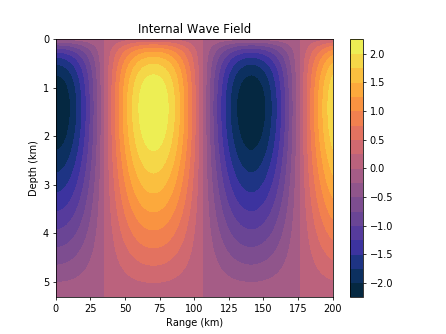

In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tools.plotbox as pltb
f,ax = plt.subplots(1)
p  = ax.contourf(iwrange/1000,iwdepth/1000,iwf.field.real,20,cmap=cmocean.cm.thermal)
pltb.setattributes(ax,"Range (km)","Depth (km)", "Internal Wave Field")
ax.invert_yaxis()
cb = f.colorbar(p)

<IPython.core.display.Javascript object>


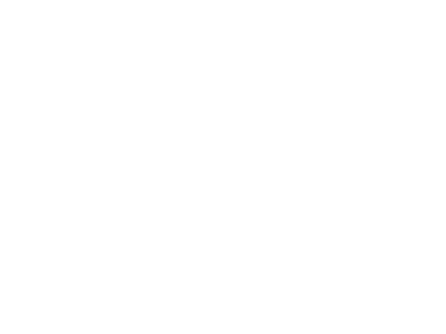

In [6]:
%matplotlib notebook
plt.plot(iwf.cannonical_bfrq())

In [7]:
plt.savefig("../figs/iwf_evp_2d.png",dpi=200)

<IPython.core.display.Javascript object>


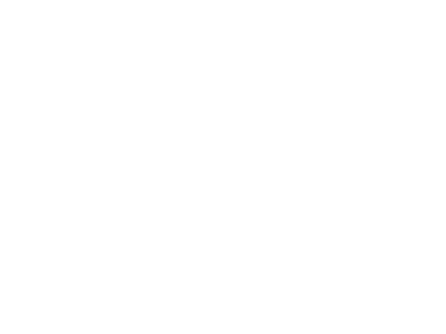

In [8]:
f , ax = plt.subplots(1)
for i,m in enumerate(iwf.modes):
    ax.scatter(iwf.hwavenumbers[m,:].real,iwf.freqs[m,:].real)
pltb.setattributes(ax,"Wavenumber","Frequency")

In [9]:
import random
import scipy.signal as signal
import functools
%matplotlib notebook

def autocovariance(x,tau):
    if tau < 0 or tau > len(x):
        print("Out of bounds : tau")
        return
    else:
        lim  = abs(round(len(x)-tau))
        xavg = np.average(x) 
        ac = 0
        for t in range(lim):
            ac += np.conjugate(x[t+tau] - xavg)*(x[t]-xavg)
        return ac/(len(x)-1.0)

def autocorrelation(x,tau):
    return autocovariance(x,tau) / autocovariance(x,0)

def displacement_field(i):
    iwf = iw.InternalWaveField(freqs=np.arange(0.01,0.08,0.001),
                           modes=np.arange(0,i),npoints=(100,100),alpha=0.4)
    return iwf.field

#Generate more realizations with different sets of modes 
set_of_df = [displacement_field(i) for i in np.arange(1,2)]

#Grab a random row 
#n = random.randint(0,set_of_df[0].shape[0])

#Plot the autocovariance of the displacement field for n modes 
#n ranging from 1 to 4
f,ax1 = plt.subplots(1)
for i,dfs in enumerate(set_of_df):
    acshs = []
    for n in range(set_of_df[0].shape[0]):
        hv = dfs[n,:]
        acsh = [autocorrelation(hv,i) for i in range(0,len(hv))]
        acshs.append(acsh)
    avg = functools.reduce(lambda x ,y : np.add(x,y),acshs) /  len(hv)
    ax1.plot(np.linspace(0,10,100),avg,label= "%d modes" % (i+1))


plotbox.setattributes(ax1,"Range (km)","Correlation",
                      "Horizontal ACV",True,np.arange(0,11,1))

f.legend()

TypeError: __init__() got an unexpected keyword argument 'npoints'

In [ ]:
import pandas as pd 
import feather

def convert_field_to_dataframe(iwf):
    zeta=iwf.field.real.flatten()
    x   = np.ndarray(shape=(1,),dtype=float)
    z   = np.ndarray(shape=(1,),dtype=float)
    
    for i,zi in enumerate(iwf.depth):
        x = iwf.range if i==0 else np.concatenate( (x, iwf.range) )
        
    for i,zi in enumerate(iwf.depth):
        z = zi*np.ones(len(iwf.range)) if (i==0) else np.concatenate( (z, zi*np.ones(len(iwf.range)) ) )
        
    return pd.DataFrame({"range" : x , "depth" : z , "disp" : zeta})

df = convert_field_to_dataframe(iwf)
%time feather.write_dataframe(df,'data/feather_test.file')

In [ ]:
df = iwf.to_dataframe()
df.head()


## Time stepping field

In [ ]:
def timestep(iwf,t):
    weights = np.array([ np.exp(2*np.pi*1j*f*t) for f in freqs ])
    iwf.update_field(weights) 
    return iwf.field

freqs = np.arange(0.01,0.08,0.001)
weights = np.ones(len(freqs))
%time iwf = iw.InternalWaveField(freqs=freqs,weights=weights,modes=np.arange(0,2),npoints=(100,100),aspect_ratio=0.4)

f,axs = plt.subplots(2,2,sharex=True,sharey=True)
axs[0,0].invert_yaxis()

for i,t in enumerate([1,4,8,12]):
    %time field = timestep(iwf,t)
    
    ax = axs[ int( np.floor(i/2) ),(i%2)] 
    p  = ax.contourf(10*iwf.range,10*iwf.depth,field.real,20,cmap=cmocean.cm.thermal)
    pltb.setattributes(ax,"Range (km)","Depth (km)", "t=%d" % (t))
    
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cabr = f.colorbar(p, cax=cbar_ax)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def timestep(iwf,t):
    weights = (1/len(freqs))*np.array([ np.exp(-2*np.pi*1j*f*t) for f in freqs ])
    iwf.update_field(weights) 
    return iwf.field

freqs = np.arange(0.01,0.08,0.001)
weights = (1/len(freqs))*np.ones(len(freqs))
%time iwf = iw.InternalWaveField(freqs=freqs,weights=weights,modes=np.arange(0,4),npoints=(100,100),aspect_ratio=0.4)


fig, ax = plt.subplots()
ax.invert_yaxis()
ax.set_xlabel('Range Km')
ax.set_ylabel('Depth Km')

def init():
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(p, cax=cbar_ax)
    cbar.set_label('Displacement (m)')
    return p

def update(time):
    timestep(iwf,time)
    ax.set_title('%.2f hours' % time)
    p = ax.contourf(10*iwf.range,10*iwf.depth,iwf.field.real,20,cmap=cmocean.cm.thermal)
    cbar_ax.cla()
    fig.colorbar(p, cax=cbar_ax)
    return p,

ani = FuncAnimation(fig, update, frames=np.linspace(0,64, 64),
                    init_func=init, blit=True)
#ani.save('../figs/animation.mp4')